In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
desired_width = 360
pd.set_option('display.width', desired_width)

from IPython.display import display, HTML
import datetime

display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
</style>
"""))
plt.rcParams['figure.figsize'] = [16,4]

In [2]:
trainDt = pd.read_csv('kc_house_train_data2.csv')
testDt = pd.read_csv('kc_house_test_data2.csv')

len(trainDt), len(testDt)

(17384, 4229)

In [3]:
example_features, example_output = (trainDt['sqft_living'], trainDt['price'])  # the [] around 'sqft_living' makes it a list

In [4]:
#print (example_features[:]) # this accesses the first row of the data the ':' indicates 'all columns'
print (example_output.loc[0]) # and the corresponding output

221900.0


# Predicting output given regression weights

Suppose we had the weights [1.0, 1.0] and the features [1.0, 1180.0] and we wanted to compute the predicted output 1.0\*1.0 + 1.0\*1180.0 = 1181.0 this is the dot product between these two arrays. If they're numpy arrayws we can use np.dot() to compute this:

In [5]:
my_weights = np.array([1.]) # the example weights
my_features = example_features[0] # we'll use the first data point
predicted_value = np.dot(my_features, my_weights)
print (predicted_value)

[1180.]


In [6]:
a = np.array([2])
b = np.array([[1,2,3],[1,2,3]])
b*a

array([[2, 4, 6],
       [2, 4, 6]])

In [7]:
len(example_features)

17384

In [8]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    if len(weights) > 1:
        predictions = np.matmul(feature_matrix, weights)
    else:
        predictions = weights* feature_matrix       

    return(predictions)

In [9]:
##If you want to test your code run the following cell:
test_predictions = predict_output(example_features, my_weights)
print (test_predictions[0]) # should be 1181.0
print (test_predictions[1]) # should be 2571.0

1180.0
2570.0


# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output.

Since the derivative of a sum is the sum of the derivatives we can compute the derivative for a single data point and then sum over data points. We can write the squared difference between the observed output and predicted output for a single point as follows:

(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)^2

Where we have k features and a constant. So the derivative with respect to weight w[i] by the chain rule is:

2\*(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)\* [feature_i]

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

2\*error\*[feature_i]

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself. In the case of the constant then this is just twice the sum of the errors!

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors. 

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).

In [10]:
def feature_derivative(errors, feature):
    # Assume that errors and feature are both numpy arrays of the same length (number of data points)
    # compute twice the dot product of these vectors as 'derivative' and return the value
    if np.array(feature).size > 1:
        derivative = 2*np.matmul(errors,feature)
    else:
        derivative = errors * feature

    return(derivative)

In [11]:
##To test your feature derivartive run the following:
trainDt['constant'] = 1
(example_features, example_output) = trainDt[['constant','sqft_living']], trainDt['price'] 
my_weights = np.array([0., 0.]) # this makes all the predictions 0
test_predictions = predict_output(example_features, my_weights) 
# just like SFrames 2 numpy arrays can be elementwise subtracted with '-': 
errors = test_predictions - example_output # prediction errors in this case is just the -example_output
feature = example_features.iloc[:,0] # let's compute the derivative with respect to 'constant', the ":" indicates "all rows"
derivative = feature_derivative(errors, feature)
print (derivative)
print (-np.sum(example_output)*2) # should be the same as derivative

-18752698920.0
-18752698920.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. We define this by requiring that the magnitude (length) of the gradient vector to be smaller than a fixed 'tolerance'.

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent we update the weight for each feature befofe computing our stopping criteria

In [12]:
from math import sqrt # recall that the magnitude/length of a vector [g[0], g[1], g[2]] is sqrt(g[0]^2 + g[1]^2 + g[2]^2)

In [191]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance):
    converged = False 
    gradient_lst = []
    ctr = 0
    weights = np.array(initial_weights) # make sure it's a numpy array
    while (not converged):
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        prediction = predict_output(feature_matrix, weights)

        # compute the errors as predictions - output
        error = prediction - output

        gradient_sum_squares = 0 # initialize the gradient sum of squares
        # while we haven't reached the tolerance yet, update each feature's weight
        for i in range(0,len(weights)): # loop over each weight
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            # compute the derivative for weight[i]:
            derivative = feature_derivative(error, feature_matrix)
            #print("***", derivative)
            # add the squared value of the derivative to the gradient sum of squares (for assessing convergence)
            gradient_sum_squares += derivative[i] * derivative[i]

            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - step_size*derivative[i]
            
        # compute the square-root of the gradient sum of squares to get the gradient magnitude:
        #print (gradient_sum_squares)
        gradient_magnitude = sqrt(gradient_sum_squares)
        ctr +=1
        if gradient_magnitude < tolerance:
            converged = True
        gradient_lst.append(gradient_magnitude)
        if ctr >3:
            print (np.gradient(gradient_lst)[ctr-1])
            if abs(np.gradient(gradient_lst)[ctr-1]) < 0.05:
                converged = True
    print (weights, ctr)
    plt.rcParams['figure.figsize'] = [8,4]
    plt.plot(gradient_lst)
    plt.semilogy()
    return(weights, gradient_lst)

A few things to note before we run the gradient descent. Since the gradient is a sum over all the data points and involves a product of an error and a feature the gradient itself will be very large since the features are large (squarefeet) and the output is large (prices). So while you might expect "tolerance" to be small, small is only relative to the size of the features. 

For similar reasons the step size will be much smaller than you might expect but this is because the gradient has such large values.

# Running the Gradient Descent as Simple Regression

First let's split the data into training and test data.
Although the gradient descent is designed for multiple regression since the constant is now a feature we can use the gradient descent function to estimat the parameters in the simple regression on squarefeet. The folowing cell sets up the feature_matrix, output, initial weights and step size for the first model:

In [205]:
# let's test out the gradient descent
initial_weights = np.array([-47000., 1.])
step_size = 7e-12
tolerance = 2.5e7
(feature_matrix1, output) = trainDt[['constant','sqft_living']], trainDt['price']

-2523732502956.0117
-655374314517.1423
-170190577495.73688
-44195861846.81816
-11476982022.99819
-2980394653.961095
-773961856.4297742
-200983777.10986066
-52184097.57568956
[-46999.88716555    281.91211918] 12


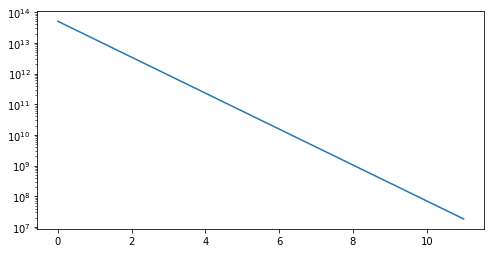

In [206]:
##Next run your gradient descent with the above parameters.

weights1, grad_lst = regression_gradient_descent(feature_matrix1, output, initial_weights, step_size, tolerance)

In [207]:
np.gradient(grad_lst)

array([-3.74240798e+13, -2.35712674e+13, -6.12109372e+12, -1.58955341e+12,
       -4.12782446e+11, -1.07193220e+11, -2.78364219e+10, -7.22868834e+09,
       -1.87717826e+09, -4.87472817e+08, -1.26583937e+08, -5.21840976e+07])

How do your weights compare to those achieved in week 1 (don't expect them to be exactly the same)? 

**Quiz Question: What is the value of the weight for sqft_living -- the second element of ‘simple_weights’ (rounded to 1 decimal place)?**

Use your newly estimated weights and your predict_output() function to compute the predictions on all the TEST data (you will need to create a numpy array of the test feature_matrix and test output first:

In [208]:
testDt['constant'] = 1
(feature_matrixtest1, outputtest) = testDt[['constant','sqft_living']], testDt['price']

In [210]:
##Now compute your predictions using test_simple_feature_matrix and your weights from above.
predict_y = predict_output(feature_matrixtest1, weights1)

In [212]:
err = outputtest - predict_y
RSS = sqrt(np.matmul(predict_y,predict_y))
RSS

38793290.36852571

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 1 (round to nearest dollar)?**

In [213]:
round(predict_y[0]), outputtest[0]

(356134.0, 310000.0)

## Comparing Results with sklearn LinearRegression library

In [214]:
regr = LinearRegression()


In [215]:
regr.fit(trainDt[['constant','sqft_living']], trainDt['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [216]:
regr.coef_

array([  0.        , 281.95883963])

In [217]:
regr.predict(testDt[['constant','sqft_living']])

array([356085.0615985 , 784662.49783662, 435033.53669499, ...,
       663420.19679557, 604208.8404732 , 240481.93735006])

# Running a multiple regression

Now we will use more than one actual feature. Use the following code to produce the weights for a second model with the following parameters:

In [223]:
(feature_matrix2, output) = trainDt[['constant','sqft_living', 'sqft_living15']], trainDt['price']
step_size = 4e-12
tolerance = 1e9

-4785112186902.83
-1346698285951.474
-272676678773.3495
-45692073199.41162
-17536586643.05481
-14372845334.45935
-13760244120.389038
-13406994890.498901
-13086258693.801758
-12775510315.622803
-12472369159.577942
-12176443508.897278
-11887541352.956238
-11605493999.361694
-11330138606.952637
-11061316380.365784
-10798872309.807007
-10542655065.065186
-10292516906.60608
-10048313600.223877
-9809904333.862122
-9577151636.404602
-9349921298.428162
-9128082294.789795
-8911506709.09613
-8700069659.931763
-8493649228.855957
-8292126390.103088
-8095384941.94397
-7903311439.689941
-7715795130.272888
-7532727888.384399
-7354004154.130066
-7179520872.159668
-7009177432.248718
-6842875611.27356
-6680519516.587585
-6522015530.720032
-6367272257.394165
-6216200468.830841
-6068713054.293793
-5924724969.863312
-5784153189.395172
-5646916656.649963
-5512936238.551331
-5382134679.559174
-5254436557.118988
-5129768238.175354
-5008057836.71405
-4889235172.306549
-4773231729.649261
-4659980619.051392
-454

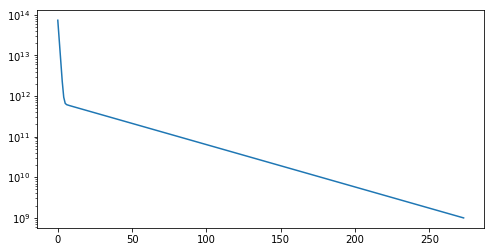

In [225]:
## Use the above parameters to estimate the model weights. Record these values for your quiz.
initial_weights = [-100000., 1., 1.]
weights2, grad_lst = regression_gradient_descent(feature_matrix2, output, initial_weights, step_size, tolerance)

Use your newly estimated weights and the predict_output function to compute the predictions on the TEST data. Don't forget to create a numpy array for these features from the test set first!

In [226]:
feature_matrixtest2, outputtest = testDt[['constant','sqft_living', 'sqft_living15']], testDt['price']
predict_y = predict_output(feature_matrixtest2, weights2)

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 2 (round to nearest dollar)?**

In [227]:
predict_y[0], outputtest[0]

(366651.41162949393, 310000.0)

In [228]:
err = outputtest - predict_y
RSS = sqrt(np.matmul(predict_y,predict_y))
RSS

38860826.617531